# مقایسه مدل‌های یادگیری ماشین برای پیش‌بینی بیماری آلزایمر

این پروژه یک تحلیل کامل برای پیش‌بینی وضعیت زوال عقل (Demented/Nondemented) با استفاده از داده‌های کلینیکی و MRI از مجموعه داده OASIS است. در این پروژه، عملکرد چهار الگوریتم طبقه‌بندی محبوب مقایسه شده است.

---

### **مراحل انجام پروژه**
فرآیند انجام این پروژه شامل مراحل کلیدی زیر است:

۱. وارد کردن کتابخانه‌ها و بارگذاری داده‌ها
در این بخش تمام کتابخانه‌های مورد نیاز برای پروژه وارد شده و دیتاست بارگذاری می‌شود.

In [ ]:
# وارد کردن کتابخانه‌های اصلی برای کار با داده و مصورسازی
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# وارد کردن مدل‌های یادگیری ماشین از Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# وارد کردن ابزارهای ارزیابی و آماده‌سازی داده
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

# بارگذاری دیتاست
df = pd.read_csv("oasis_longitudinal.csv")

۲. کاوش و پاک‌سازی داده‌ها (Data Cleaning & Exploration)
در این مرحله، نگاهی اولیه به داده‌ها می‌اندازیم، مقادیر گمشده را مدیریت می‌کنیم و داده‌ها را برای تحلیل آماده می‌سازیم.

In [ ]:
# نمایش ۵ سطر اول دیتاست برای درک ساختار آن
print("نمایش اولیه داده‌ها:")
display(df.head())

# بررسی اطلاعات کلی دیتافریم مانند نوع داده‌ها و تعداد مقادیر غیرنال
print("\nاطلاعات کلی دیتافریم:")
df.info()

# بررسی تعداد مقادیر گمشده (NaN) در هر ستون
print("\nتعداد مقادیر گمشده در هر ستون:")
print(df.isna().sum())

# بررسی و حذف ردیف‌های تکراری (در این دیتاست تکراری وجود ندارد)
print(f"\nتعداد ردیف‌های تکراری: {df.duplicated().sum()}")

# جایگزینی مقادیر گمشده در ستون SES با میانه (Median)
# چون توزیع این ستون ممکن است چولگی داشته باشد، میانه انتخاب بهتری است
df["SES"].fillna(df["SES"].median(), inplace=True)

# جایگزینی مقادیر گمشده در ستون MMSE با میانگین (Mean)
df["MMSE"].fillna(df["MMSE"].mean(), inplace=True)

print("\nتعداد مقادیر گمشده پس از پاک‌سازی:")
print(df.isna().sum())

۳. مصورسازی و تحلیل داده‌ها (Data Visualization)
در این بخش، با استفاده از نمودارها، توزیع و روابط بین متغیرها را بررسی می‌کنیم.

In [ ]:
# برای تحلیل، فقط اولین ویزیت هر فرد را در نظر می‌گیریم تا شمارش تکراری نداشته باشیم
first_visit_df = df.loc[df['Visit'] == 1].copy()

# جایگزینی برچسب 'Converted' با 'Demented'
# افرادی که وضعیتشان به زوال عقل تغییر کرده، در نهایت در گروه دارای زوال عقل قرار می‌گیرند
first_visit_df['Group'] = first_visit_df['Group'].replace('Converted', 'Demented')
df['Group'] = df['Group'].replace('Converted', 'Demented')

# رسم نمودار توزیع فراوانی گروه‌ها
plt.figure(figsize=(8, 6))
sns.countplot(x='Group', data=first_visit_df, palette='viridis')
plt.title('Distribution of Individuals in Demented and Nondemented Groups', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

تحلیل نمودار بالا:
نمودار نشان می‌دهد که تعداد افراد در دو گروه "Demented" (دارای زوال عقل) و "Nondemented" (بدون زوال عقل) تقریباً متعادل است. این موضوع برای ساخت یک مدل پیش‌بینی‌کننده خوب، نکته مثبتی است.

In [ ]:
# مقایسه توزیع سنی دو گروه
plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='Age', hue='Group', fill=True, palette='plasma')
plt.title('Age Distribution Comparison of Demented and Nondemented Groups', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(50, 100)
plt.legend(title='Group', labels=['Nondemented', 'Demented'])
plt.show()

تحلیل نمودار بالا:
همانطور که مشاهده می‌شود، تراکم سنی افراد دارای زوال عقل (Demented) در بازه ۷۰ تا ۸۰ سال بیشتر است. همچنین، تعداد افراد بالای ۹۰ سال در گروه بدون زوال عقل (Nondemented) بیشتر به نظر می‌رسد که می‌تواند نشان‌دهنده طول عمر کمتر افراد مبتلا به آلزایمر باشد.

۴. آماده‌سازی داده‌ها برای مدل‌سازی
در این بخش، داده‌های دسته‌بندی را به فرمت عددی تبدیل کرده و مجموعه داده را به دو بخش آموزشی و آزمایشی تقسیم می‌کنیم.

In [ ]:
# تبدیل متغیرهای متنی (دسته‌بندی) به عددی
# مدل‌های یادگیری ماشین فقط با داده‌های عددی کار می‌کنند
for column in ['M/F', 'Group', 'Hand']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

print("نمایش داده‌ها پس از تبدیل به فرمت عددی:")
display(df.head())

# تعریف متغیرهای ویژگی (X) و متغیر هدف (y)
feature_cols = ["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV", "nWBV", "ASF"]
X = df[feature_cols].values
y = df['Group'].values

# تقسیم داده‌ها به دو مجموعه آموزشی (70%) و آزمایشی (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"\nاندازه مجموعه آموزشی: {X_train.shape}")
print(f"اندازه مجموعه آزمایشی: {X_test.shape}")

۵. تعریف توابع ارزیابی مدل
برای جلوگیری از تکرار کد، توابعی برای ارزیابی عملکرد مدل‌ها تعریف می‌کنیم. این توابع معیارهای مختلفی مانند ماتریس درهم‌ریختگی، دقت و نمودار ROC را محاسبه و نمایش می‌دهند.

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """این تابع ماتریس درهم‌ریختگی را رسم می‌کند."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Nondemented', 'Demented'],
                yticklabels=['Nondemented', 'Demented'])
    plt.title('ماتریس درهم‌ریختگی (Confusion Matrix)', fontsize=14)
    plt.ylabel('برچسب واقعی', fontsize=12)
    plt.xlabel('برچسب پیش‌بینی شده', fontsize=12)
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    """این تابع نمودار ROC را برای مدل رسم می‌کند."""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('نرخ مثبت کاذب (False Positive Rate)', fontsize=12)
    plt.ylabel('نرخ مثبت واقعی (True Positive Rate)', fontsize=12)
    plt.title('منحنی ROC', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(model, X_test, y_test):
    """این تابع عملکرد کلی یک مدل را گزارش می‌دهد."""
    y_pred = model.predict(X_test)
    
    # گزارش طبقه‌بندی
    print("گزارش طبقه‌بندی (Classification Report):")
    print(classification_report(y_test, y_pred, target_names=['Nondemented', 'Demented']))
    
    # دقت مدل
    acc = accuracy_score(y_test, y_pred)
    print(f"دقت مدل (Accuracy): {acc:.4f}\n")
    
    # رسم ماتریس درهم‌ریختگی
    plot_confusion_matrix(y_test, y_pred)
    
    # رسم نمودار ROC
    # (برای مدل‌هایی که تابع predict_proba دارند)
    if hasattr(model, "predict_proba"):
        plot_roc_curve(model, X_test, y_test)
        
    return acc

۶. ساخت، آموزش و ارزیابی مدل‌ها
در این بخش، مدل‌های مختلف یادگیری ماشین را بر روی داده‌های آموزشی، آموزش داده و سپس عملکرد آن‌ها را روی داده‌های آزمایشی ارزیابی می‌کنیم.

۶.۱. رگرسیون لجستیک (Logistic Regression)

In [ ]:
# ساخت و آموزش مدل رگرسیون لجستیک
log_reg = LogisticRegression(solver='liblinear', max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "Logistic Regression Evaluation", "="*15)
accuracy_log_reg = evaluate_model(log_reg, X_test, y_test)

۶.۲. درخت تصمیم (Decision Tree)

In [ ]:
# ساخت و آموزش مدل درخت تصمیم
dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dec_tree.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "Decision Tree Evaluation", "="*15)
accuracy_dec_tree = evaluate_model(dec_tree, X_test, y_test)

۶.۳. ماشین بردار پشتیبان (SVM)

In [ ]:
# ساخت و آموزش مدل SVM
# probability=True برای رسم نمودار ROC ضروری است
svm_model = SVC(kernel="linear", C=0.1, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "Support Vector Machine (SVM) Evaluation", "="*15)
accuracy_svm = evaluate_model(svm_model, X_test, y_test)

۶.۴. k-نزدیک‌ترین همسایه (KNN)

In [ ]:
# ساخت و آموزش مدل KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "ارزیابی k-نزدیک‌ترین همسایه", "="*15)
accuracy_knn = evaluate_model(knn_model, X_test, y_test)

۷. مقایسه نهایی مدل‌ها
در نهایت، دقت مدل‌های مختلف را در کنار هم مقایسه می‌کنیم تا بهترین مدل را برای این مسئله شناسایی کنیم.

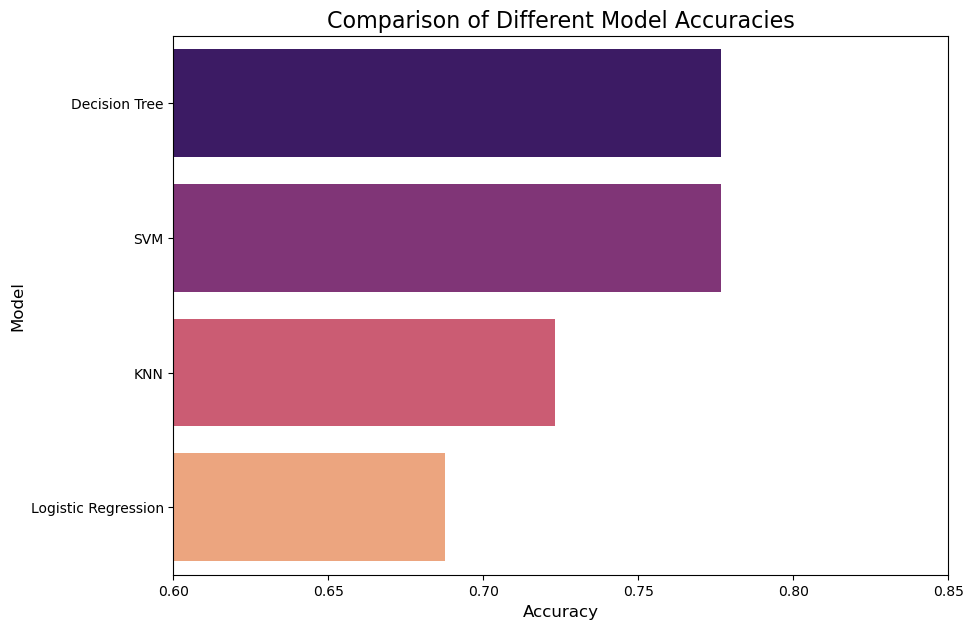


جدول مقایسه دقت مدل‌ها:


,Model,Accuracy
1,Decision Tree,0.776786
2,SVM,0.776786
3,KNN,0.723214
0,Logistic Regression,0.687500


In [90]:
# ایجاد یک دیتافریم برای مقایسه دقت مدل‌ها
model_accuracies = {
    'Logistic Regression': accuracy_log_reg,
    'Decision Tree': accuracy_dec_tree,
    'SVM': accuracy_svm,
    'KNN': accuracy_knn
}

accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(10, 7))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='magma')
plt.title('Comparison of Different Model Accuracies', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.6, 0.85) # تنظیم بازه محور x برای نمایش بهتر تفاوت‌ها
plt.show()

print("\nجدول مقایسه دقت مدل‌ها:")
display(accuracy_df)

نتیجه‌گیری نهایی:
بر اساس نمودار و جدول بالا، می‌توان مشاهده کرد که مدل‌های رگرسیون لجستیک و ماشین بردار پشتیبان (SVM) بهترین عملکرد را با دقت‌های مشابه در این مسئله از خود نشان داده‌اند. مدل درخت تصمیم نیز عملکرد خوبی داشته، در حالی که مدل KNN کمترین دقت را ثبت کرده است.